In [38]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from matplotlib import colors

In [39]:
input_folder = "/Users/shuyang/Data/DTM/LakeNipissing-DTM-A/DTM"  # Change to your folder path
adjusted_output_folder = "/Users/shuyang/Data/DTM/LakeNipissing-DTM-A/DTM_adj"  # Change to desired output folder for adjusted rasters
pseudocolor_output_folder = "/Users/shuyang/Data/DTM/LakeNipissing-DTM-A/pseudocolor"  # Change to desired output folder for pseudocolor images


# input_folder = "Elora/DTM"  # Change to your folder path
# adjusted_output_folder = "Elora/DTM_adj"  # Change to desired output folder for adjusted rasters
# pseudocolor_output_folder = "Elora/pseudocolor"  # Change to desired output folder for pseudocolor images

In [40]:
def find_global_min_max(folder):
    global_min, global_max = float('inf'), float('-inf')
    
    for filename in os.listdir(folder):
        if filename.endswith('.img') and not filename.startswith('._'):
            filepath = os.path.join(folder, filename)
            try:
                with rasterio.open(filepath) as dataset:
                    data = dataset.read(1, resampling=Resampling.nearest)  # Read first band
                    no_data_value = dataset.nodata

                    # Mask out NoData values before finding min and max
                    if no_data_value is not None:
                        data = np.ma.masked_equal(data, no_data_value)

                    # Update global min and max
                    min_value = data.min()
                    max_value = data.max()
                    global_min = min(global_min, min_value)
                    global_max = max(global_max, max_value)

            except rasterio.errors.RasterioIOError:
                print(f"Skipping invalid file: {filename}")
    
    return global_min, global_max

In [41]:

# Step 1: Find the minimum and maximum values
min_value, max_value = find_global_min_max(input_folder)
global_min = min_value
global_max = max_value
print(f"Minimum value of all rasters: {min_value}")
print(f"Maximum value of all rasters: {max_value}")

KeyboardInterrupt: 

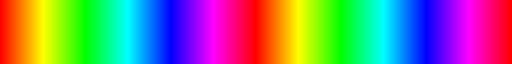

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, hsv_to_rgb

def double_hue_cmap(name='double_hue'):
    # Create an array of values from 0 to 1
    x = np.linspace(0, 1, 2560)

    # Map x to hue values that cycle from 0 to 2 (twice around the hue circle)
    h = np.mod(2 * x, 1)

    # Saturation and Value are fixed at 1
    s = np.ones_like(h) 
    v = np.ones_like(h) 

    # Stack to get HSV values
    hsv = np.stack((h, s, v), axis=1)
    # Convert HSV to RGB
    rgb = hsv_to_rgb(hsv)

    # Create a ListedColormap
    cmap = ListedColormap(rgb, name=name)
    return cmap

# Create the custom colormap
double_cmap = double_hue_cmap()
double_cmap

In [42]:
# Function to create a high-resolution colormap by interpolation
def create_high_res_colormap(cmap_name='terrain', num_colors=1024):
    base_cmap = plt.get_cmap(cmap_name)
    color_indices = np.linspace(0, 1, num_colors)
    high_res_cmap = colors.LinearSegmentedColormap.from_list(
        'high_res', base_cmap(color_indices), N=num_colors
    )
    return high_res_cmap

# Main function for creating pseudocolor images using a custom colormap
def create_pseudocolor_images_from_original(folder, min_value, max_value, output_folder, cmap):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    norm = colors.Normalize(vmin=min_value, vmax=max_value)

    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.img') and not filename.startswith('._'):
            filepath = os.path.join(folder, filename)
            try:
                with rasterio.open(filepath) as dataset:
                    data = dataset.read(1)
                    
                    # Normalize data and apply high-resolution colormap
                    normalized_data = norm(data)
                    rgba_img = cmap(normalized_data)
                    rgb_img = np.uint8(rgba_img[:, :, :3] * 255)  # Convert RGBA to RGB

                    # Save as RGB GeoTIFF
                    output_path = os.path.join(output_folder, filename.replace('.img', '_pseudocolor.tif'))
                    with rasterio.open(
                        output_path,
                        'w',
                        driver='GTiff',
                        height=rgb_img.shape[0],
                        width=rgb_img.shape[1],
                        count=3,
                        dtype='uint8',
                        crs=dataset.crs,
                        transform=dataset.transform
                    ) as dst:
                        # Write RGB channels
                        for i in range(3):
                            dst.write(rgb_img[:, :, i], i + 1)

            except rasterio.errors.RasterioIOError:
                print(f"Skipping invalid file: {filename}")

In [45]:
# Step 1: Create the custom colormap
custom_cmap = create_high_res_colormap(cmap_name='terrain', num_colors=5560)

# Step 2: Generate pseudocolor images using the custom colormap
create_pseudocolor_images_from_original(input_folder, min_value, max_value, pseudocolor_output_folder, double_cmap)


/Users/b/miniforge3/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


In [58]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling



# Step 2: Rescale raster files based on the global min and max
def rescale_and_save(folder, output_folder, global_min, global_max):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for filename in os.listdir(folder):
        if filename.endswith('.img'):
            filepath = os.path.join(folder, filename)
            with rasterio.open(filepath) as dataset:
                data = dataset.read(1, resampling=Resampling.nearest)  # Read first band
                
                # Perform rescaling using global min and max
                adjusted_data = (data - global_min) / (global_max - global_min) * 65535
                
                # Preserve NaN areas (if any)
                adjusted_data[np.isnan(data)] = np.nan
                
                # Save adjusted raster as GeoTIFF
                output_path = os.path.join(output_folder, filename.replace('.img', '_rescaled.tif'))
                with rasterio.open(
                    output_path,
                    'w',
                    driver='GTiff',
                    height=dataset.height,
                    width=dataset.width,
                    count=1,
                    dtype=rasterio.uint16,  # Save as 16-bit unsigned integer
                    crs=dataset.crs,
                    transform=dataset.transform
                ) as dst:
                    dst.write(adjusted_data.astype(rasterio.uint16), 1)





# Rescale and save all files using global min and max
rescale_and_save(input_folder, adjusted_output_folder, global_min, global_max)


In [10]:
def print_lookup_table(global_min, global_max):
    # Generate a sample of original values between the global min and max
    original_values = np.linspace(global_min, global_max, num=10)  # 10 evenly spaced values for the table

    # Calculate corresponding scaled values
    scaled_values = (original_values - global_min) / (global_max - global_min) * 65535

    # Calculate vertical exaggeration
    vertical_exaggeration = 65535 / (global_max - global_min)

    # Print the lookup table
    print("Lookup Table: Original Value -> Scaled Value")
    print("------------------------------------------")
    for original, scaled in zip(original_values, scaled_values):
        print(f"{original:.2f} -> {scaled:.2f}")

    # Print vertical exaggeration
    print("\nVertical Exaggeration:")
    print(f"VE = {vertical_exaggeration:.2f}")
    

print_lookup_table(global_min, global_max)



Lookup Table: Original Value -> Scaled Value
------------------------------------------
341.82 -> 0.00
351.22 -> 7281.67
360.63 -> 14563.33
370.03 -> 21845.00
379.43 -> 29126.67
388.84 -> 36408.33
398.24 -> 43690.00
407.64 -> 50971.67
417.05 -> 58253.33
426.45 -> 65535.00

Vertical Exaggeration:
VE = 774.37


In [19]:
1/774.37 * 500

0.6456861706935961

In [21]:
0.003*500

1.5